In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy_indexed as npi
from labellines import labelLines
import os
import sys

'''
Script to compare cas and stability setup JV scan pixel by pixel
replace file path below
'''

# cas_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\cas_analyzed\0\Data\photo - 0p_0.0Sun_Scan0.txt"
# ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\0p\Nov-08-2023 15_57_40lightID1scan.csv"



'\nScript to compare cas and stability setup JV scan pixel by pixel\nreplace file path below\n'

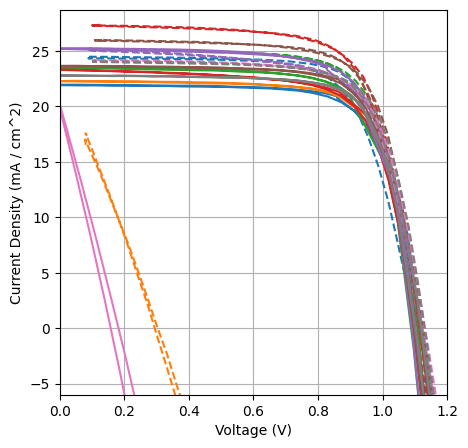

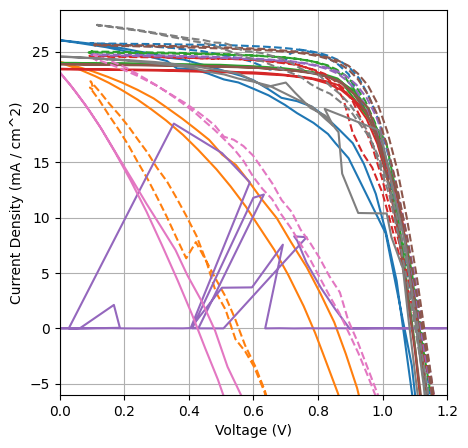

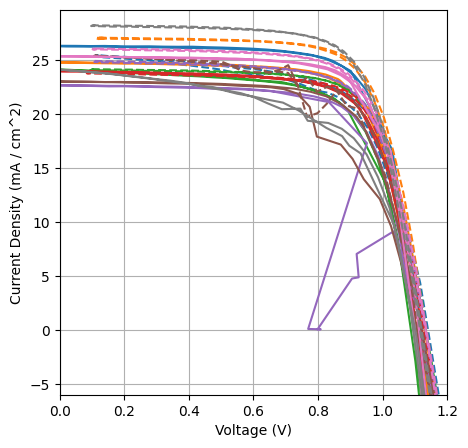

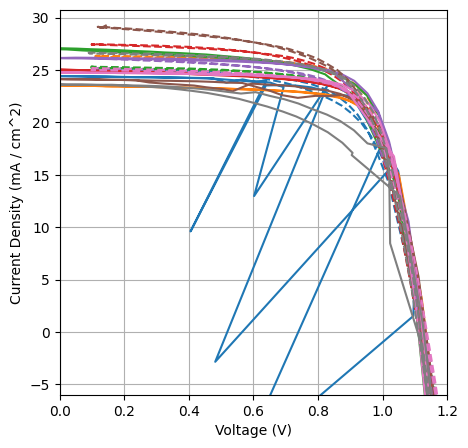

C:\Users\achen\AppData\Local\Temp\ipykernel_24800\2878777175.py:320: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_plot_data_ff, labels=labels_ff)


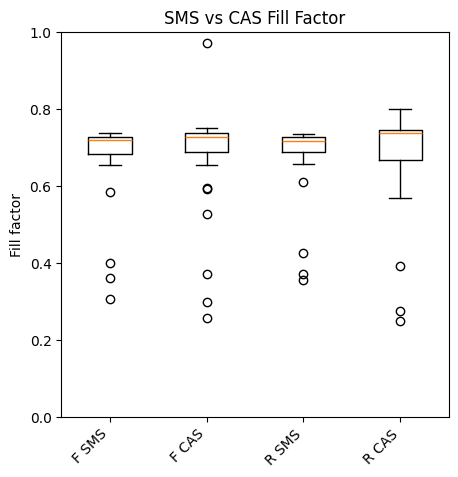

C:\Users\achen\AppData\Local\Temp\ipykernel_24800\2878777175.py:336: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_plot_data_voc, labels=labels_voc)


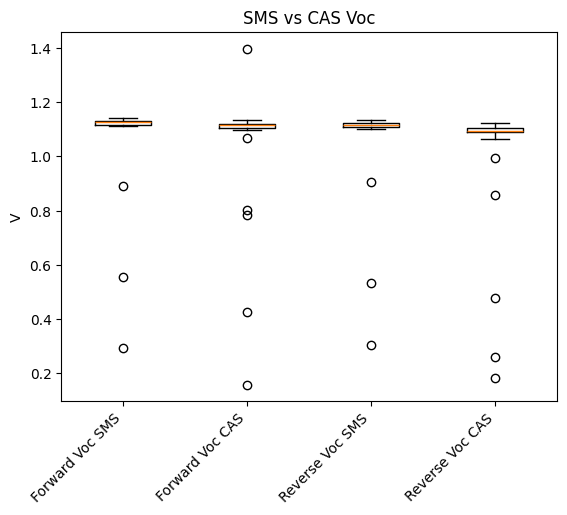

C:\Users\achen\AppData\Local\Temp\ipykernel_24800\2878777175.py:343: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_plot_data_jsc, labels=labels_jsc)


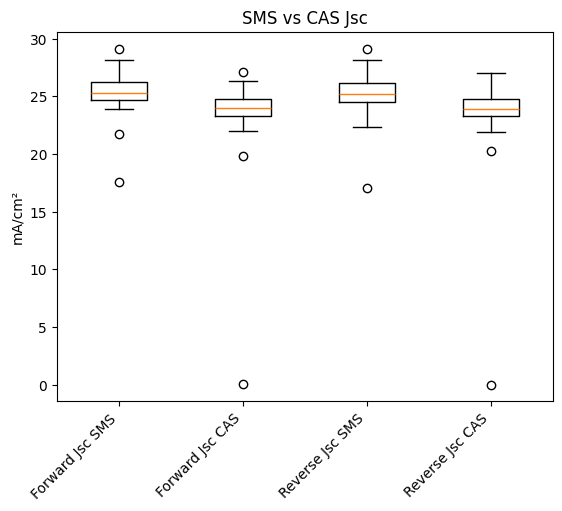

Total Average FF diff (% fill factor) = 0.0730881173844861
Total Average VOC diff (V)= 0.101687096282961
Total Average JSC diff (mA/cm²)= 1.932731596262209
Total Average FF diff (% fill factor) Raw = -0.0035872094739011493
Total Average VOC diff Raw(V)= 0.029849354854926284
Total Average JSC diff Raw(mA/cm²)= 1.272450287869887


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy_indexed as npi
from labellines import labelLines
from matplotlib.font_manager import FontProperties
np.set_printoptions(linewidth=100)   # or pick a big number, e.g. 200
import os
import sys
import re
from scipy.interpolate import interp1d	 # pip install scipy

# def get_stats_arr(voltage, current):


def get_stats(voltage, current):
	ff_all = []
	jsc_all = []
	voc_all = []
	for i in range(voltage.shape[1]):
		V = np.asarray(voltage[:, i])
		I = np.asarray(current[:, i])
		if V.shape != I.shape:
			raise ValueError("voltages and currents must have the same shape")

		# 1) Voc: interpolate V at I=0
		#    Sort by current for reliable interpolation
		sort_I = np.argsort(I)
		I_sorted = I[sort_I]
		V_sorted_by_I = V[sort_I]
		Voc = float(np.interp(0.0, I_sorted, V_sorted_by_I))

		# 2) Isc: interpolate I at V=0
		sort_V = np.argsort(V)
		V_sorted = V[sort_V]
		I_sorted_by_V = I[sort_V]
		Isc = float(np.interp(0.0, V_sorted, I_sorted_by_V))

		# 3) Maximum power point
		P = V * I
		idx_mp = np.argmax(P)
		Vmp = float(V[idx_mp])
		Imp = float(I[idx_mp])

		# 4) Fill Factor
		FF = (Vmp * Imp) / (Voc * Isc) if (Voc * Isc) != 0 else np.nan

		ff_all.append(FF)
		jsc_all.append(Isc)
		voc_all.append(Voc)


	return np.array(ff_all), np.array(jsc_all), np.array(voc_all)

def plot_difference(ss_file_path, cas_directory, cas_str, plot_size, roll = 0):
	# cas_directory = ""
	# cas_directory = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\2025-03-04-- cas New PCB 4 Device comparison\devices\device_2"
	np.set_printoptions(threshold=np.inf)
	data = []
	cell_area = 0
	# ss_file_path = ""
	# ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\Mar-04-2025 16_42_19__4 Device First Test\Mar-04-2025_16-44-53__4 Device First Test__ID2__mppt.csv"
	if ss_file_path != "":
		arr = np.loadtxt(ss_file_path, delimiter=",", dtype=str)
		header_row = np.where(arr == "Time")[0][0]

		meta_data = {}
		for data in arr[:header_row, :2]:
			meta_data[data[0]] = data[1]

		headers = arr[header_row, :]
		arr = arr[header_row + 1 :, :]

		data = arr[:, 2:-1]
		cell_area = float(meta_data["Cell Area (mm^2)"])
		pixel_V = data[:, ::2][:, ::-1].astype(float)
		pixel_mA = data[:, 1::2][:, ::-1].astype(float) / float(meta_data["Cell Area (mm^2)"])
		# if ("Cell Area (mm^2)" in meta_data):
		#	 pixel_mA /= float(meta_data["Cell Area (mm^2)"])
		# else:
		#	 pixel_mA /= 0.128

	all_files = []

	if cas_directory != "":
		# print(cas_directory)
		for root, dirs, files in os.walk(cas_directory):
			for file in files:
				if file.endswith('.csv'):
					file_path = os.path.join(root, file)
					all_files.append(file_path)

	cas_voltage = []
	cas_current = []

	# Process each file
	for file_path in all_files:
		if cas_str in file_path:
			try:
				data = np.genfromtxt(
					file_path,
					delimiter=',',
					comments='#',
					skip_header=0,
					encoding='cp1252'  # Specify the correct encoding
				)
				voltage = data[:, 0]
				current = data[:,1]

				mask		   = np.isfinite(voltage) & np.isfinite(current)
				voltage_clean  = voltage[mask]
				current_clean  = current[mask]/cell_area

				cas_voltage.append(voltage_clean)
				cas_current.append(current_clean)
			except Exception as e:
				print(f"Error processing {file_path}: {e}")

	cas_voltage = np.array(cas_voltage).T
	cas_current = np.array(cas_current).T


	# ax.spines['bottom'].set_position(('data', 0))

	ss_half = pixel_V.shape[0] // 2
	cas_half = cas_voltage.shape[0] // 2

	cas_Fv = cas_voltage[:cas_half,:]
	cas_Fa = cas_current[:cas_half,:]
	ff_cas_f, jsc_cas_f, voc_cas_f = get_stats(cas_Fv, cas_Fa)
	cas_Rv = cas_voltage[cas_half:,:]
	cas_Ra = cas_current[cas_half:,:]
	ff_cas_R, jsc_cas_r, voc_cas_r = get_stats(cas_Rv, cas_Ra)

	sms_Fv = pixel_V[ss_half:,:]
	sms_Fa = pixel_mA[ss_half:,:]
	ff_sms_f, jsc_sms_f, voc_sms_f = get_stats(sms_Fv, sms_Fa)
	sms_Rv = pixel_V[:ss_half,:]
	sms_Ra = pixel_mA[:ss_half,:]
	ff_sms_R, jsc_sms_r, voc_sms_r = get_stats(sms_Rv, sms_Ra)
	# print("Stats", ff_sms_R, jsc_sms_r, voc_sms_r)

	colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

	plt.figure(figsize=(plot_size))
	plt.xlim(0,1.2)
	top = max(np.max(pixel_mA), np.max(current))*1.05
	plt.ylim(bottom = -6, top = top)
	plt.xlabel('Voltage (V)')
	plt.ylabel('Current Density (mA / cm^2)')
	plt.grid()
	ax = plt.gca()

	for i in range(8):
		# plt.title(f"Pixel{i}")

		lineName = "SMS"
		if ss_file_path:
			plt.plot(pixel_V[:,i],
					 pixel_mA[:,i],
					 linestyle='--',
					 color=colors[i % len(colors)],
					 label = lineName)
		if True:
			# plt.hlines(pce[i], x_start, x_end, label="cas_pce" + str(i + 1))
			plt.plot(cas_voltage[:,i],
					 cas_current[:,i],
					 color=colors[i % len(colors)],
					 label = "CAS")

		# print(f"cas forward:{ff_cas_f[i]}")
		# print(f"sms forward:{ff_sms_f[i]}")
		# print(f"cas reverse:{ff_cas_R[i]}")
		# print(f"sms reverse:{ff_sms_R[i]}")

		# plt.legend(bbox_to_anchor=(0.25, 0.16))
	# plt.legend()
	plt.savefig(
			"JV_Plot.png",         # output filename (extension defines format)
		)
	plt.show()


	ff_diff_forward = np.abs(ff_sms_f - ff_cas_f)
	ff_diff_reverse = np.abs(ff_sms_R - ff_cas_R)
	voc_diff_forward = np.abs(voc_sms_f - voc_cas_f)
	voc_diff_reverse = np.abs(voc_sms_r - voc_cas_r)
	jsc_diff_forward = np.abs(jsc_sms_f - jsc_cas_f)
	jsc_diff_reverse = np.abs(jsc_sms_r - jsc_cas_r)

	diff_forward_raw  = ff_sms_f - ff_cas_f
	diff_reverse_raw  = ff_sms_R - ff_cas_R
	ff_diff_raw = np.concatenate((diff_forward_raw, diff_reverse_raw))
	voc_raw_forward   =  voc_sms_f - voc_cas_f
	voc_raw_reverse   =  voc_sms_r - voc_cas_r
	voc_diff_raw      = np.concatenate((voc_raw_forward, voc_raw_reverse))
	jsc_raw_forward   =  jsc_sms_f - jsc_cas_f
	jsc_raw_reverse   =  jsc_sms_r - jsc_cas_r
	jsc_diff_raw      = np.concatenate((jsc_raw_forward, jsc_raw_reverse))


	box_plot_data_ff = [ff_sms_f, ff_cas_f,ff_sms_R, ff_cas_R]

	box_plot_data_voc = [voc_sms_f, voc_cas_f, voc_sms_r, voc_cas_r]

	box_plot_data_jsc = [jsc_sms_f, jsc_cas_f, jsc_sms_r, jsc_cas_r]

	return ff_diff_forward, voc_diff_forward, ff_diff_reverse, voc_diff_reverse, jsc_diff_forward, jsc_diff_reverse, box_plot_data_ff, box_plot_data_voc, box_plot_data_jsc, ff_diff_raw, voc_diff_raw, jsc_diff_raw

files = []
# for i in range(1,5):
# 	files.append([
# 		rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\April-03-2025 cas\devices\{i}",
# 		rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_18_09\Apr-03-2025_19-18-19__ID{i}__light__scan.csv"
# 	])

r"""
Best performing
for i in range(4,5):

for i in range(4,5):
	files.append([
		rf"C:\Users\Andrew Chen\Dropbox\code\Stability-Setup\data\Apr-10-2025 18_28_52\cas\devices\{i}",
		rf"C:\Users\Andrew Chen\Dropbox\code\Stability-Setup\data\Apr-10-2025 18_28_52\Apr-10-2025_18-39-43__ID{i}__light__scan.csv"
	])

"""

# Trial with CAS holder
# sms_files = [
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\Apr-03-2025_19-41-45__ID1__light__scan.csv",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\Apr-03-2025_19-41-45__ID2__light__scan.csv",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\Apr-03-2025_19-41-45__ID3__light__scan.csv",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\Apr-03-2025_19-41-45__ID4__light__scan.csv",
# ]
# cas_files = [
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\devices\1",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\devices\2",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\devices\3",
# 	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_41_27\devices\4",
# ]

# Trial with SMS sample holder
sms_files = [
	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-26-38__ID1__light__scan.csv",
	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-32-23__ID2__light__scan.csv",
	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-32-23__ID3__light__scan.csv",
	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\Apr-29-2025_17-26-38__ID4__light__scan.csv",
]
cas_files = [
	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\1",
	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\2",
	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\3",
	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-29-2025 17_25_13 leo devices\devices\4",
]

for sms, cas in zip(sms_files, cas_files):
	files.append([
	 sms,
	 cas
	])

all_ff_diff = []
all_ff_diff_raw = []
all_voc_diff = []
all_voc_diff_raw = []
all_jsc_diff = []
all_jsc_diff_raw = []
box_plot_data_voc = [[],[],[],[]]
box_plot_data_ff = [[],[],[],[]]
box_plot_data_jsc = [[],[],[],[]]
for ss_file, cas in files:
	ff_diff_forward, voc_diff_forward, ff_diff_reverse, voc_diff_reverse, jsc_diff_forward, jsc_diff_reverse, temp_ff, temp_voc, temp_jsc, ff_diff_raw, voc_diff_raw, jsc_diff_raw = plot_difference(ss_file, cas, "_1_0", (5,5))
	# print(np.argsort(ff_diffs_forward))
	# print(np.argsort(ff_diffs_reverse))
	# print(np.argsort(voc_diffs_forward))
	# print(np.argsort(voc_diffs_reverse))

	# print(f"FF diff foward {np.mean(ff_diff_forward)}, FF diff Reverse{np.mean(ff_diff_reverse)}")
	# print(f"voc diff forward {np.mean(voc_diff_forward)}, voc diff reverse {np.mean(voc_diff_reverse)}")

	all_ff_diff.extend(ff_diff_forward)
	all_ff_diff.extend(ff_diff_reverse)
	all_voc_diff.extend(voc_diff_forward)
	all_voc_diff.extend(voc_diff_reverse)
	all_jsc_diff.extend(jsc_diff_forward)
	all_jsc_diff.extend(jsc_diff_reverse)

	all_ff_diff_raw.extend(ff_diff_raw)
	all_voc_diff_raw.extend(voc_diff_raw)
	all_jsc_diff_raw.extend(jsc_diff_raw)

	for i in range(4):
		box_plot_data_voc[i].extend(temp_voc[i])
		box_plot_data_ff[i].extend(temp_ff[i])
		box_plot_data_jsc[i].extend(temp_jsc[i])

all_ff_diff = np.asarray(all_ff_diff)
all_voc_diff = np.asarray(all_voc_diff)
all_jsc_diff = np.asarray(all_jsc_diff)
mask = all_ff_diff <= 1
all_ff_diff_filtered = all_ff_diff[mask]
all_voc_diff_filtered = all_voc_diff[mask]
all_jsc_diff_filtered = all_jsc_diff[mask]

all_ff_diff_raw = np.asarray(all_ff_diff_raw)
all_voc_diff_raw = np.asarray(all_voc_diff_raw)
all_jsc_diff_raw = np.asarray(all_jsc_diff_raw)
mask = (all_ff_diff_raw >= -1) & (all_ff_diff_raw <= 1)
all_ff_diff_raw_filtered = all_ff_diff_raw[mask]
all_voc_diff_raw_filtered = all_voc_diff_raw[mask]
all_jsc_diff_raw_filtered = all_jsc_diff_raw[mask]



labels_ff = ['F SMS', 'F CAS',
			 'R SMS', 'R CAS']

FIGSIZE = (5, 5)     # e.g. 8.6 cm × 6.6 cm  (single-column width)
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.boxplot(box_plot_data_ff, labels=labels_ff)

ax.set_xticklabels(labels_ff, rotation=45, ha='right')
ax.set_title("SMS vs CAS Fill Factor")
ax.set_ylabel("Fill factor")		  # “V” → probably “–” for dimensionless FF

# —-------------------------------------
ax.set_ylim(0, 1)   # <-- change the numbers to whatever bounds you want
# —-------------------------------------

plt.savefig(
			"Comparison_FF_BoxPlot.png",         # output filename (extension defines format)
		)
plt.show()

labels_voc = ['Forward Voc SMS', 'Forward Voc CAS','Reverse Voc SMS','Reverse Voc CAS',]
plt.boxplot(box_plot_data_voc, labels=labels_voc)
plt.xticks(rotation=45, ha='right')  # Rotate labels diagonally
plt.title("SMS vs CAS Voc")
plt.ylabel("V")
plt.show()

labels_jsc = ['Forward Jsc SMS', 'Forward Jsc CAS','Reverse Jsc SMS','Reverse Jsc CAS',]
plt.boxplot(box_plot_data_jsc, labels=labels_jsc)
plt.xticks(rotation=45, ha='right')  # Rotate labels diagonally
plt.title("SMS vs CAS Jsc")
plt.ylabel("mA/cm²")
plt.show()

# print(box_plot_data_ff)
print(f"Total Average FF diff (% fill factor) = {np.mean(all_ff_diff_filtered)}")
print(f"Total Average VOC diff (V)= {np.mean(all_voc_diff_filtered)}")
print(f"Total Average JSC diff (mA/cm²)= {np.mean(all_jsc_diff_filtered)}")
print(f"Total Average FF diff (% fill factor) Raw = {np.mean(all_ff_diff_raw_filtered)}")
print(f"Total Average VOC diff Raw(V)= {np.mean(all_voc_diff_raw_filtered)}")
print(f"Total Average JSC diff Raw(mA/cm²)= {np.mean(all_jsc_diff_raw_filtered)}")

In [ ]:
import numpy as np
from scipy import stats

bias = all_ff_diff_raw_filtered.mean()
mae = np.abs(all_ff_diff_raw_filtered).mean()
sd   = all_ff_diff_raw_filtered.std(ddof=1)
rmse = np.sqrt((all_ff_diff_raw_filtered**2).mean())
ci95 = stats.t.interval(0.95, len(all_ff_diff_raw_filtered)-1, loc=bias, scale=sd/np.sqrt(len(all_ff_diff_raw_filtered)))
loa  = (bias - 1.96*sd, bias + 1.96*sd)
ci95 = (round(ci95[0], 4), round(ci95[1], 4))
loa  = (round(loa[0],  4), round(loa[1],  4))

print(f"Fill factor bias = {bias:.4f}")
print(f"Fill factor mae   = {mae:.4f}")
print(f"Fill factor rmse = {rmse:.4f}")
print(f"Fill factor ci95 = {ci95}")
print(f"Fill factor loa  = {loa}")


bias = all_voc_diff_raw_filtered.mean()
mae = np.abs(all_voc_diff_raw_filtered).mean()
sd   = all_voc_diff_raw_filtered.std(ddof=1)
rmse = np.sqrt((all_voc_diff_raw_filtered**2).mean())
ci95 = stats.t.interval(0.95, len(all_voc_diff_raw_filtered)-1, loc=bias, scale=sd/np.sqrt(len(all_voc_diff_raw_filtered)))
loa  = (bias - 1.96*sd, bias + 1.96*sd)
ci95 = (round(ci95[0], 4), round(ci95[1], 4))
loa  = (round(loa[0],  4), round(loa[1],  4))

print(f"Voc bias = {bias:.4f}")
print(f"Voc mae   = {mae:.4f}")
print(f"Voc rmse = {rmse:.4f}")
print(f"Voc ci95 = {ci95}")
print(f"Voc loa  = {loa}")


bias = all_jsc_diff_raw_filtered.mean()
mae = np.abs(all_jsc_diff_raw_filtered).mean()
sd   = all_jsc_diff_raw_filtered.std(ddof=1)
rmse = np.sqrt((all_jsc_diff_raw_filtered**2).mean())
ci95 = stats.t.interval(0.95, len(all_jsc_diff_raw_filtered)-1, loc=bias, scale=sd/np.sqrt(len(all_jsc_diff_raw_filtered)))
loa  = (bias - 1.96*sd, bias + 1.96*sd)
ci95 = (round(ci95[0], 4), round(ci95[1], 4))
loa  = (round(loa[0],  4), round(loa[1],  4))

print(f"Jsc bias = {bias:.4f}")
print(f"Jsc mae   = {mae:.4f}")
print(f"Jsc rmse = {rmse:.4f}")
print(f"Jsc ci95 = {ci95}")
print(f"Jsc loa  = {loa}")




Fill factor bias = -0.0055
Fill factor mae   = 0.0649
Fill factor rmse = 0.1189
Fill factor ci95 = (-0.0354, 0.0244)
Fill factor loa  = (-0.2401, 0.229)
Voc bias = 0.0244
Voc mae   = 0.0916
Voc rmse = 0.2307
Voc ci95 = (-0.0334, 0.0821)
Voc loa  = (-0.4288, 0.4775)
Jsc bias = 1.3222
Jsc mae   = 1.9173
Jsc rmse = 2.3526
Jsc ci95 = (0.8323, 1.8121)
Jsc loa  = (-2.5218, 5.1663)


: 

In [1]:

cas_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\cas_analyzed\100\Data\photo - 100p_1.0Sun_Scan0.txt"
ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\100p\Nov-08-2023 14_40_34lightID1scan.csv"

cas = np.loadtxt(cas_file_path,
					 delimiter="\t",
					 dtype=str)
cas = cas.T
cas = cas[:,1:].astype(float)

arr = np.loadtxt(ss_file_path,
					 delimiter=",",
					 dtype=str)
NUM_DEVICES = int((arr.shape[1]-2)/16)
device_to_pixels = {}
for i in range(NUM_DEVICES):
	device_to_pixels[i] = [j + 8*i for j in range(8)]

headers = arr[6,:]
header_dict = {value: index for index, value in enumerate(headers)}
arr = arr[7:, :]
voltage = arr[:, 2]
length = (len(headers) - 1)


jvList = []
for i in range(2, length): #remove timing and voltage output from array
	jvList.append(arr[:,i])

for i in range(0,len(jvList),2):
	# print(i)
	jvList[i] = [float(j) for j in jvList[i]]
	# jvList[i] = [float(v) - 5*float(j)*0.001 for v, j in zip(jvList[i], jvList[i+1])]
	jvList[i+1] = [float(x)/0.128 for x in jvList[i+1]]

# print(jvList)

plot_size = (10,8)
maxX = 1.3
minX = 0
maxY = 26
minY = -2

for i in range(0,len(cas),4):

	plot_title_orig = ss_file_path[:-4].split("\\")[-1]

	plt.figure(figsize=plot_size)
	# plt.xlim(minX,maxX)
	# plt.ylim(minY, maxY)
	plt.title(plot_title_orig)
	plt.xlabel('Bias [V]')
	plt.ylabel('Jmeas [mAcm-2]')
	# plt.ylabel('Jmeas [mA/cm]')
	plt.subplots_adjust(left=0.086, bottom=0.06, right=0.844, top=0.927, wspace=0.2, hspace=0.2)
	# print(dead_pixel, show_dead_pixels)
	# print(i)
	lineName = "Pixel " + str(int(i/4) + 1)
	# print(jvList[i],jvList[i+1])
	plt.plot(jvList[i//2],jvList[i//2+1], label = lineName)

	lineName = "cas " + str(int(i/4) + 1)
	# print(cas[i],cas[i+1])

	plt.plot(np.concatenate((cas[len(cas)-(i+4)],cas[len(cas)-(i+2)])),np.concatenate((cas[len(cas)-(i+3)],cas[len(cas)-(i+1)])), label = lineName)

	ax = plt.gca()
	ax.spines['bottom'].set_position('zero')
	labelLines(plt.gca().get_lines(), zorder=2.5)

	plt.legend(bbox_to_anchor=(1.18, 1))
	plt.plot()

NameError: name 'np' is not defined

In [ ]:

# cas_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\cas_analyzed\100\Data\photo - 100p_1.0Sun_Scan0.txt"
# ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\100p\Nov-08-2023 14_40_34lightID1scan.csv"

cas = np.loadtxt(cas_file_path,
					 delimiter="\t",
					 dtype=str)
cas = cas.T
cas = cas[:,1:].astype(float)

arr = np.loadtxt(ss_file_path,
					 delimiter=",",
					 dtype=str)
NUM_DEVICES = int((arr.shape[1]-2)/16)
device_to_pixels = {}
for i in range(NUM_DEVICES):
	device_to_pixels[i] = [j + 8*i for j in range(8)]

headers = arr[6,:]
header_dict = {value: index for index, value in enumerate(headers)}
arr = arr[7:, :]
voltage = arr[:, 2]
length = (len(headers) - 1)


jvList = []
for i in range(2, length): #remove timing and voltage output from array
	jvList.append(arr[:,i])

for i in range(0,len(jvList),2):
	# print(i)
	jvList[i] = [float(j) for j in jvList[i]]
	# jvList[i] = [float(v) + 5*float(j)*0.001 for v, j in zip(jvList[i], jvList[i+1])]
	jvList[i+1] = [float(x)/0.128 for x in jvList[i+1]]




# print(jvList)

plot_size = (13,10)

maxX = 1.5
minX = 0
maxY = 25
minY = -130
plot_title_orig = "100% cas"

plt.figure(figsize=plot_size)
plt.xlim(minX,maxX)
plt.ylim(minY, maxY)
plt.title(plot_title_orig)
plt.xlabel('Bias [V]')
plt.ylabel('Jmeas [mAcm-2]')
# plt.ylabel('Jmeas [mA/cm]')
plt.subplots_adjust(left=0.086, bottom=0.06, right=0.844, top=0.927, wspace=0.2, hspace=0.2)

for i in range(0,len(cas),4):
	# print(dead_pixel, show_dead_pixels)
	# print(i)
	cas_volt = np.concatenate((cas[len(cas)-(i+4)],cas[len(cas)-(i+2)]))
	cas_curr = np.concatenate((cas[len(cas)-(i+3)],cas[len(cas)-(i+1)]))
	# break
	cas_pce = max(cas_volt*cas_curr)
	setup_pce = max(np.array(jvList[i//2])*np.array(jvList[i//2+1]))

	# diff = np.diff()

	lineName = "Pixel " + str(int(i/4) + 1)
	# print(jvList[i],jvList[i+1])
	plt.plot(jvList[i//2],jvList[i//2+1], label = lineName)

	lineName = "cas " + str(int(i/4) + 1)
	# print(cas[i],cas[i+1])
	plt.plot(np.concatenate((cas[len(cas)-(i+4)],cas[len(cas)-(i+2)])),np.concatenate((cas[len(cas)-(i+3)],cas[len(cas)-(i+1)])), label = lineName)

	# plt.plot(np.concatenate((cas[len(cas)-(i+4)],cas[len(cas)-(i+2)])),np.concatenate((cas[len(cas)-(i+3)],cas[len(cas)-(i+1)])), label = lineName)
plt.xticks(np.arange(minX, maxX, 0.1))
ax = plt.gca()
ax.spines['bottom'].set_position('zero')
labelLines(plt.gca().get_lines(), zorder=2.5)
plt.grid()
plt.legend(bbox_to_anchor=(1.18, 1))
plt.plot()